In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

In [2]:
!pip install wandb
import wandb
# Replace with your actual API key
api_key = "17dab9d1bbdc37c41831799a4b0b50d3e97400c5"

# Login to Weights & Biases
wandb.login(key=api_key)
project_name = 'DDQN_T1vsT2_AB'

wandb: Currently logged in as: rishi1906 (iitm_aero). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
import wandb

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [5]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:

# Define the Dueling DQN model
class DuelingDQN_T1(nn.Module):
    def __init__(self, input_size, output_size, fc1_units, fc2_units, seed):
        super(DuelingDQN_T1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.advantage = nn.Linear(fc2_units, output_size)
        self.value = nn.Linear(fc2_units, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        advantage = self.advantage(x)
        value = self.value(x)
        q_values = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        return q_values


In [7]:

# Define the Dueling DQN model
class DuelingDQN_T2(nn.Module):
    def __init__(self, input_size, output_size, fc1_units, fc2_units, seed):
        super(DuelingDQN_T2, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.advantage = nn.Linear(fc2_units, output_size)
        self.value = nn.Linear(fc2_units, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        advantage = self.advantage(x)
        value = self.value(x)
        q_values = value + (advantage - advantage.max(dim=-1, keepdim=True)[0])
        return q_values


In [8]:
# Define the ReplayBuffer class
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


In [9]:
# Define the agent
class Agent_T1():
    def __init__(self, state_size, action_size, fc1_units, fc2_units, buffer_size, batch_size, lr, update_every, gamma, eps_end, eps_decay, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.lr = lr
        self.update_every = update_every
        self.gamma = gamma
        self.seed = random.seed(seed)
        self.q_network = DuelingDQN_T1(state_size, action_size, fc1_units, fc2_units, seed).to(device)
        self.target_network = DuelingDQN_T1(state_size, action_size, fc1_units, fc2_units, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        self.t_step = 0
        self.eps_end = eps_end
        self.eps_decay = eps_decay

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        # wandb.log({'train loss': loss})
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-1, 1)  # Gradient clipping
        self.optimizer.step()


In [10]:
# Define the agent
class Agent_T2():
    def __init__(self, state_size, action_size, fc1_units, fc2_units, buffer_size, batch_size, lr, update_every, gamma, eps_end, eps_decay, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.lr = lr
        self.update_every = update_every
        self.gamma = gamma
        self.seed = random.seed(seed)
        self.q_network = DuelingDQN_T2(state_size, action_size, fc1_units, fc2_units, seed).to(device)
        self.target_network = DuelingDQN_T2(state_size, action_size, fc1_units, fc2_units, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        self.t_step = 0
        self.eps_end = eps_end
        self.eps_decay = eps_decay

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        # wandb.log({'train loss': loss})
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.q_network.parameters():
            param.grad.data.clamp_(-1, 1)  # Gradient clipping
        self.optimizer.step()


In [11]:
def dqn(agent, env, n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores_window = deque(maxlen=100)
    episode_list_epsgrdy = []
    average_scores_epsgrdy = []
    average_regret_epsgrdy = []
    cumulative_regret_epsgrdy = []
    cummulative_regret_window=[]
    regret_window = []
    cumulative_regret = 0  # Initialize cumulative regret
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        regret = 0  # Initialize regret for this episode
        # cumulative_regret = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            optimal_action = np.argmax(agent.q_network(torch.from_numpy(state).float().unsqueeze(0)).cpu().data.numpy())
            optimal_reward = env.step(optimal_action)[1]  # Get the reward for the optimal action
            regret += optimal_reward - reward  # Calculate regret for this time step
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break


        scores_window.append(score)
        average_score = np.mean(scores_window)
        average_scores_epsgrdy.append(average_score)


        regret_window.append(regret)
        average_regret = np.mean(regret_window)
        average_regret_epsgrdy.append(average_regret)

        cumulative_regret += average_regret  # Update cumulative regret

        # cummulative_regret_window.append(cumulative_regret)
        # cummulative_average_regret = np.mean(cummulative_regret_window)
        cummulative_average_regret = average_regret
        cumulative_regret_epsgrdy.append(cumulative_regret)

        episode_list_epsgrdy.append(i_episode)
        wandb.log({'average_score': average_score})
        wandb.log({'average_regret': average_regret})
        wandb.log({"cummulative_regret": cumulative_regret})

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tRegret: {:.2f}'.format(i_episode, average_score, regret))

        if i_episode % 100 == 0  and np.mean(scores_window) >= -100:
            wandb.log({"episode_no": i_episode})
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break
        eps = max(eps_end, eps_decay*eps)

    return episode_list_epsgrdy, average_scores_epsgrdy, average_regret_epsgrdy

In [12]:

# Initialize wandb with your project name
wandb.init(project=project_name)

In [13]:
env = gym.make('Acrobot-v1')
env.seed(0)
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [14]:
config_T1 = {
    'state_size': state_shape,
    'action_size': action_shape,
    'BUFFER_SIZE': int(1e5),
    'BATCH_SIZE': 64,
    'LR': 0.0001,
    'UPDATE_EVERY': 20,
    'fc1_units': 128,
    'fc2_units': 64,
    'eps_start': 1,
    'eps_end': 0.01,
    'eps_decay': 0.995,
    'gamma': 0.99,
    'n_episodes': 1000,
    'max_t': 1000
}

# sweep_id_T1 = wandb.sweep(sweep=sweep_config_T1, project=project_name)

In [15]:
config_T2 = {
    'state_size': state_shape,
    'action_size': action_shape,
    'BUFFER_SIZE': int(1e5),
    'BATCH_SIZE': 64,
    'LR': 0.0001,
    'UPDATE_EVERY': 20,
    'fc1_units': 128,
    'fc2_units': 64,
    'eps_start': 1,
    'eps_end': 0.01,
    'eps_decay': 0.995,
    'gamma': 0.99,
    'n_episodes': 1000,
    'max_t': 1000
}

# sweep_id_T2 = wandb.sweep(sweep=sweep_config_T2, project=project_name)


In [16]:
average_scores_T1 = []
cumm_regret_T1 = []

In [17]:
average_scores_T2 = []
cumm_regret_T2 = []

In [18]:


# Define the main function for hyperparameter tuning
def AvgOverExperiments_T1():

    # env = gym.make('Acrobot-v1')
    # env.seed(0)
    # state_shape = env.observation_space.shape[0]
    # no_of_actions = env.action_space.n

    # with wandb.init() as run:
    # Get the hyperparameters for this run
    # config = wandb.config

    begin_time = datetime.datetime.now()
    # env = gym.make('Acrobot-v1')
    # env.seed(0)

    # Create the agent with the hyperparameters
    agent = Agent_T1(state_size=config_T1['state_size'], action_size=config_T1['action_size'], fc1_units=config_T1['fc1_units'], fc2_units=config_T1['fc2_units'], buffer_size=config_T1['BUFFER_SIZE'], batch_size=config_T1['BATCH_SIZE'], lr=config_T1['LR'], update_every=config_T1['UPDATE_EVERY'], gamma=config_T1['gamma'], eps_end=config_T1['eps_end'], eps_decay=config_T1['eps_decay'],seed = 0)

    # Train the agent and get the scores
    # episode_list_epsgrdy, average_scores_epsgrdy = dqn(agent, env, n_episodes=config.n_episodes, max_t=config.max_t, eps_start=config.eps_start, eps_end=config.eps_end, eps_decay=config.eps_decay)

    episode_list_epsgrdy, average_scores_epsgrdy, cumulative_regret_epsgrdy = dqn(agent, env, n_episodes=config_T1['n_episodes'], max_t=config_T1['max_t'], eps_start=config_T1['eps_start'], eps_end=config_T1['eps_end'], eps_decay=config_T1['eps_decay'])

    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    # Log the final average score to wandb
    # wandb.log({"Average Score": average_scores_epsgrdy})
    # wandb.log({"Average Score": cumulative_regret})
    print(average_scores_epsgrdy)
    print('\n')
    print(cumulative_regret_epsgrdy)
    average_scores_T1.append(average_scores_epsgrdy)
    cumm_regret_T1.append(cumulative_regret_epsgrdy)
        # return [average_scores_epsgrdy, cumulative_regret]


In [19]:


# Define the main function for hyperparameter tuning
def AvgOverExperiments_T2():

    # env = gym.make('Acrobot-v1')
    # env.seed(0)
    # state_shape = env.observation_space.shape[0]
    # no_of_actions = env.action_space.n

    # with wandb.init() as run:
    # Get the hyperparameters for this run
    # config = wandb.config

    begin_time = datetime.datetime.now()
    # env = gym.make('Acrobot-v1')
    # env.seed(0)

    # Create the agent with the hyperparameters
    agent = Agent_T2(state_size=config_T2['state_size'], action_size=config_T2['action_size'], fc1_units=config_T2['fc1_units'], fc2_units=config_T2['fc2_units'], buffer_size=config_T2['BUFFER_SIZE'], batch_size=config_T2['BATCH_SIZE'], lr=config_T2['LR'], update_every=config_T2['UPDATE_EVERY'], gamma=config_T2['gamma'], eps_end=config_T2['eps_end'], eps_decay=config_T2['eps_decay'],seed = 0)

    # Train the agent and get the scores
    # episode_list_epsgrdy, average_scores_epsgrdy = dqn(agent, env, n_episodes=config.n_episodes, max_t=config.max_t, eps_start=config.eps_start, eps_end=config.eps_end, eps_decay=config.eps_decay)

    episode_list_epsgrdy, average_scores_epsgrdy, cumulative_regret_epsgrdy = dqn(agent, env, n_episodes=config_T2['n_episodes'], max_t=config_T2['max_t'], eps_start=config_T2['eps_start'], eps_end=config_T2['eps_end'], eps_decay=config_T2['eps_decay'])

    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    # Log the final average score to wandb
    # wandb.log({"Average Score": average_scores_epsgrdy})
    # wandb.log({"Average Score": cumulative_regret})
    print(average_scores_epsgrdy)
    print('\n')
    print(cumulative_regret_epsgrdy)
    average_scores_T2.append(average_scores_epsgrdy)
    cumm_regret_T2.append(cumulative_regret_epsgrdy)
        # return [average_scores_epsgrdy, cumulative_regret]


In [20]:
# # Average over 5 exeriments

# average_scores, cumm_regret = [], []
num_expts = 5
for i in range(num_expts):
    print("Experiment: %d" % (i + 1))
    AvgOverExperiments_T1()
    AvgOverExperiments_T2()
    # episode_average_scores, episode_cumm_regret =  wandb.agent(sweep_id, function=AvgOverExperiments, count=1)
    # wandb.agent(sweep_id, function=AvgOverExperiments, count=1)
    # average_scores.append(episode_average_scores)
    # cumm_regret.append(episode_cumm_regret)
# wandb.finish()


Experiment: 1


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -87.71	Regret: 0.00

Environment solved in 100 episodes!	Average Score: -87.71
0:01:02.884847
[-251.0, -251.0, -251.0, -251.0, -251.0, -251.0, -251.0, -243.875, -233.88888888888889, -225.8, -213.36363636363637, -203.16666666666666, -195.3846153846154, -188.92857142857142, -183.8, -178.375, -173.64705882352942, -167.5, -162.3684210526316, -157.15, -153.61904761904762, -150.45454545454547, -146.34782608695653, -148.0, -144.56, -141.92307692307693, -139.7037037037037, -136.67857142857142, -135.48275862068965, -133.4, -130.80645161290323, -128.5, -126.33333333333333, -125.02941176470588, -123.71428571428571, -121.58333333333333, -119.67567567567568, -118.52631578947368, -117.12820512820512, -116.025, -114.6829268292683, -113.42857142857143, -112.6046511627907, -111.54545454545455, -110.82222222222222, -110.1304347826087, -110.04255319148936, -108.83333333333333, -107.6938775510204, -107.18, -106.25490196078431, -106.09615384615384, -105.09433962264151, -104.85185

In [21]:
average_scores_T1 = np.array(average_scores_T1)
cumm_regret_T1 = np.array(cumm_regret_T1)

mean_average_scores_T1 = np.mean(average_scores_T1, axis=0)
std_mean_average_scores_T1 = np.std(average_scores_T1, axis=0)

mean_cumm_regret_T1 = np.mean(cumm_regret_T1, axis=0)
mean_cumm_regret_T1 = np.std(cumm_regret_T1, axis=0)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
average_scores_T2 = np.array(average_scores_T2)
cumm_regret_T2 = np.array(cumm_regret_T2)

mean_average_scores_T2 = np.mean(average_scores_T2, axis=0)
std_mean_average_scores_T2 = np.std(average_scores_T2, axis=0)

mean_cumm_regret_T2 = np.mean(cumm_regret_T2, axis=0)
mean_cumm_regret_T2 = np.std(cumm_regret_T2, axis=0)


In [23]:
def plot_avg_curves(avg_reward_1,reward_std_1, avg_step_1, step_std_1,   avg_reward_2, reward_std_2, avg_step_2, step_std_2, step_size = 10 ):

    trunc_avg_reward_1 = avg_reward_1[0::step_size]
    tunc_reward_std_1 = reward_std_1[0::step_size]

    trunc_avg_step_1 = avg_step_1[0::step_size]
    tunc_step_std_1 = step_std_1[0::step_size]

    trunc_avg_reward_2 = avg_reward_2[0::step_size]
    tunc_reward_std_2 = reward_std_2[0::step_size]

    trunc_avg_step_2 = avg_step_2[0::step_size]
    tunc_step_std_2 = step_std_2[0::step_size]

    # Plot the average rewards with mean and standard deviation
    plt.figure()
    plt.plot(trunc_avg_reward_1, label='Mean T1')
    plt.fill_between(range(step_size), trunc_avg_reward_1 + tunc_reward_std_1, trunc_avg_reward_1 - tunc_reward_std_1, alpha=0.5, label=' Std Dev T1')
    plt.plot(trunc_avg_reward_2, label='Mean T2')
    plt.fill_between(range(step_size), trunc_avg_reward_2 + tunc_reward_std_2, trunc_avg_reward_2 - tunc_reward_std_2, alpha=0.5, label=' Std Dev T2')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Average Total Reward vs Episode Comparison for T1 vs T2 Dueling DQN for CartPole-v1 Environment')
    plt.legend()
    # plt.savefig( "RvsE " +".pdf")
    # files.download(exp_no+"_RvsE.png")
    plt.show()



   # Plot the average rewards with mean and standard deviation
    plt.figure()
    plt.plot(trunc_avg_step_1, label='Mean T1')
    plt.fill_between(range(step_size), trunc_avg_step_1 + tunc_step_std_1, trunc_avg_step_1 - tunc_step_std_1, alpha=0.5, label=' Std Dev T1')
    plt.plot(trunc_avg_step_2, label='Mean T2')
    plt.fill_between(range(step_size), trunc_avg_step_2 + tunc_step_std_2, trunc_avg_step_2 - tunc_step_std_2, alpha=0.5, label=' Std Dev T2')
    plt.xlabel('Episode')
    plt.ylabel('Average Regret')
    plt.title('Average Regret vs Episode Comparison for T1 vs T2 Dueling DQN for CartPole-v1 Environment')
    plt.legend()
    plt.show()

    # Plot the average rewards with mean
    plt.figure()
    plt.plot(avg_step_1, label='Mean T1')
    plt.plot(avg_step_2, label='Mean T2')
    plt.xlabel('Episode')
    plt.ylabel('Cummulative Average Regret')
    plt.title('Cummulative Average Regret vs Episode Comparison for T1 vs T2 Dueling DQN for CartPole-v1 Environment')
    plt.legend()
    plt.show()



In [ ]:
plot_avg_curves(mean_average_scores_T1, std_mean_average_scores_T1, mean_cumm_regret_T1, mean_cumm_regret_T1, mean_average_scores_T2, std_mean_average_scores_T2, mean_cumm_regret_T2, mean_cumm_regret_T2, step_size = 1)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_avg_curves(avg_reward, step_size=1):
#     max_length = max(len(reward) for reward in avg_reward)

#     # Initialize arrays to store sum and count of non-zero values for each index
#     sum_non_zero = np.zeros(max_length)
#     count_non_zero = np.zeros(max_length)

#     # Iterate over each list in avg_reward
#     for reward in avg_reward:
#         for j, value in enumerate(reward):
#             if j % step_size == 0:
#                 sum_non_zero[j] += value
#                 count_non_zero[j] += 1

#     # Calculate mean and standard deviation using non-zero values
#     mean_avg_reward = sum_non_zero / count_non_zero
#     mean_reward_std = np.zeros(max_length)

#     for reward in avg_reward:
#         for j, value in enumerate(reward):
#             if j % step_size == 0:
#                 mean_reward_std[j] += (value - mean_avg_reward[j]) ** 2

#     mean_reward_std = np.sqrt(mean_reward_std / count_non_zero)

#     # Plot the average rewards with mean and standard deviation
#     plt.figure()
#     plt.plot(mean_avg_reward, label='Mean')
#     plt.fill_between(range(0, max_length, step_size), mean_avg_reward + mean_reward_std, mean_avg_reward - mean_reward_std, alpha=0.5, label=' Std Dev')
#     plt.xlabel('Episode')
#     plt.ylabel('Average Total Reward')
#     plt.title('Average Total Reward vs Episode')
#     plt.legend()
#     plt.show()

# # Example usage:
# # average_scores = [[1, 2, 3], [4, 5, 6, 7], [8, 9]]

# plot_avg_curves(average_scores_T1, average_scores_T2, step_size=1)


In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_curves(avg_reward_1, avg_reward_2, step_size=1):
    mean_avg_reward_1 = np.mean(avg_reward_1, axis=0)
    mean_avg_reward_2 = np.mean(avg_reward_2, axis=0)
    std_avg_reward_1 = np.std(avg_reward_1, axis=0)
    std_avg_reward_2 = np.std(avg_reward_2, axis=0)

    # Ensure that the length of the x-axis data matches the length of the y-axis data
    length = min(len(mean_avg_reward_1), len(mean_avg_reward_2))
    x = np.arange(0, length * step_size, step_size)

    plt.figure()
    plt.plot(x, mean_avg_reward_1[:length], label='Mean T1')
    plt.fill_between(x, mean_avg_reward_1[:length] + std_avg_reward_1[:length], mean_avg_reward_1[:length] - std_avg_reward_1[:length], alpha=0.5, label=' Std Dev T1')
    plt.plot(x, mean_avg_reward_2[:length], label='Mean T2')
    plt.fill_between(x, mean_avg_reward_2[:length] + std_avg_reward_2[:length], mean_avg_reward_2[:length] - std_avg_reward_2[:length], alpha=0.5, label=' Std Dev T2')
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Average Total Reward vs Episode')
    plt.legend()
    plt.show()

# Example usage:
# average_scores_T1 = np.array([[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]])
# average_scores_T2 = np.array([[3, 4, 5, 6, 7], [4, 5, 6, 7, 8]])
# plot_avg_curves(average_scores_T1, average_scores_T2, step_size=10)


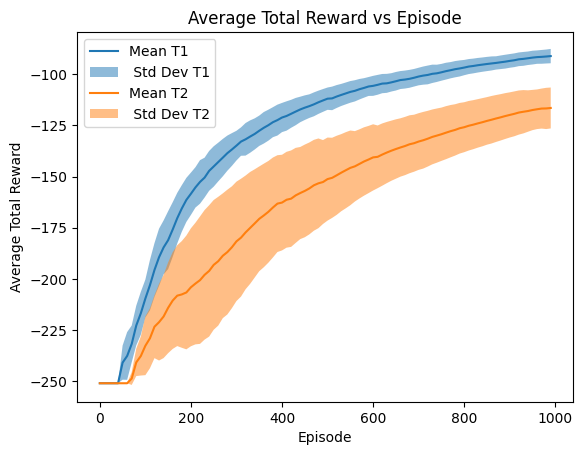

In [49]:
plot_avg_curves(average_scores_T1, average_scores_T2, step_size=10)

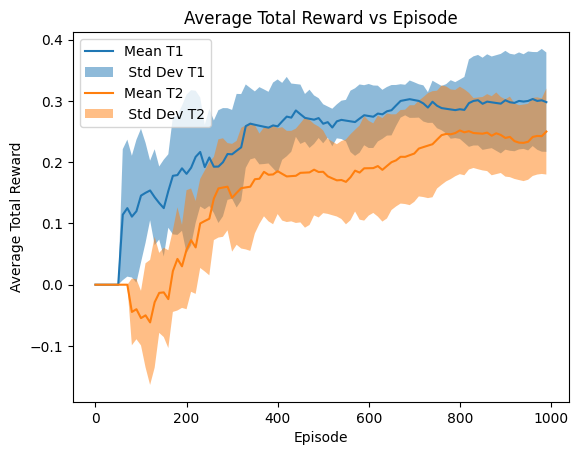

In [50]:
plot_avg_curves(cumm_regret_T1, cumm_regret_T2, step_size=10)